In [1]:
import nest_asyncio
import stan
import numpy as np
import pandas as pd
from os import path
from RLmodels import QLearningModel
# from RLmodels import qLearningModel_5params_simNoPlot
from RLmodels import RestlessBanditDecoupled
from RLmodels import QLearningModelSim, myPairPlot, getSessionFitParams
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import re
from scipy.stats import norm
from scipy.stats import halfcauchy
from scipy.stats import cauchy
from sklearn.linear_model import LinearRegression
import pickle
import json
nest_asyncio.apply()

In [2]:
# load fitted samples
name = 'modelSimLikeStanTest'
saveDir = path.expanduser('~/capsule/scratch/'+name)
if not os.path.exists(saveDir):
    print(f'Model {name} not found.')
else:
    paramsSim = pd.read_csv(saveDir+'/paramsSim.csv', index_col=0)
    paramsFit = pd.read_csv(saveDir+'/paramsFit.csv', index_col=0)
    summary = pd.read_csv(saveDir+'/summary.csv', index_col=0)

    with open(saveDir+'/samples', 'rb') as pickle_file:
        fit = pickle.load(pickle_file)
        
    with open(saveDir+'/basicInfo', 'r') as json_file:
        b = json.load(json_file)

    with open(saveDir+'/choiceSim', 'r') as json_file:
        choiceSim = json.load(json_file)

    with open(saveDir+'/outcomeSim', 'r') as json_file:
        outcomeSim = json.load(json_file)


In [3]:
paramsFit = getSessionFitParams(summary, b['paramNames'], focus='median')

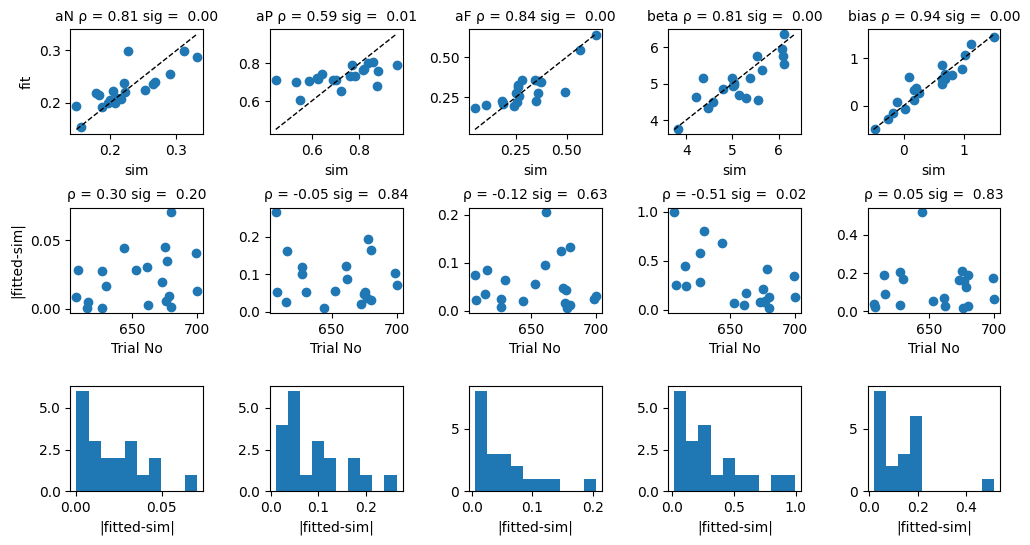

In [4]:
# summarize fitting results: compare session level fit with sim
plt.figure(figsize=(12, 6))
plt.subplots_adjust(hspace=0.7, wspace=0.5)
for paramInd in range(len(b['paramNames'])):
    plt.subplot(3, len(b['paramNames']), paramInd+1)
    paramSimCurr = paramsSim[b['paramNames'][paramInd]]
    paramFit = paramsFit[b['paramNames'][paramInd]]
    
    rho, p = pearsonr(paramSimCurr, paramFit)
    low = np.min(np.array([np.min(paramSimCurr), np.min(paramFit)]))
    high = np.max(np.array([np.max(paramSimCurr), np.max(paramFit)]))
    plt.scatter(paramSimCurr, paramFit)
    plt.title(f"{b['paramNames'][paramInd]} ρ = {rho:.2f} sig = {p: .2f}", fontsize = 10)
    plt.xlabel('sim')
    plt.plot([low, high], [low, high], 'k', lw = 1, ls = '--')
    if paramInd == 0:
        plt.ylabel('fit')

diff = paramsFit - paramsSim.drop(columns=['sessionLen'])
diff['sessionLen'] = paramsSim['sessionLen']
for paramInd in range(len(b['paramNames'])):
    plt.subplot(3, len(b['paramNames']), paramInd+1 + len(b['paramNames']))
    plt.scatter(diff['sessionLen'], np.abs(diff[b['paramNames'][paramInd]].values))
    rho, p = spearmanr(diff['sessionLen'], np.abs(diff[b['paramNames'][paramInd]].values))
    plt.title(f"ρ = {rho:.2f} sig = {p: .2f}", fontsize = 10)
    if paramInd == 0:
        plt.ylabel('|fitted-sim|')
    plt.xlabel('Trial No')
    plt.subplot(3, len(b['paramNames']), paramInd+1 + 2*len(b['paramNames']))
    plt.hist(np.abs(diff[b['paramNames'][paramInd]].values))
    plt.xlabel('|fitted-sim|')

Text(0.5, 0.98, 'Animal level')

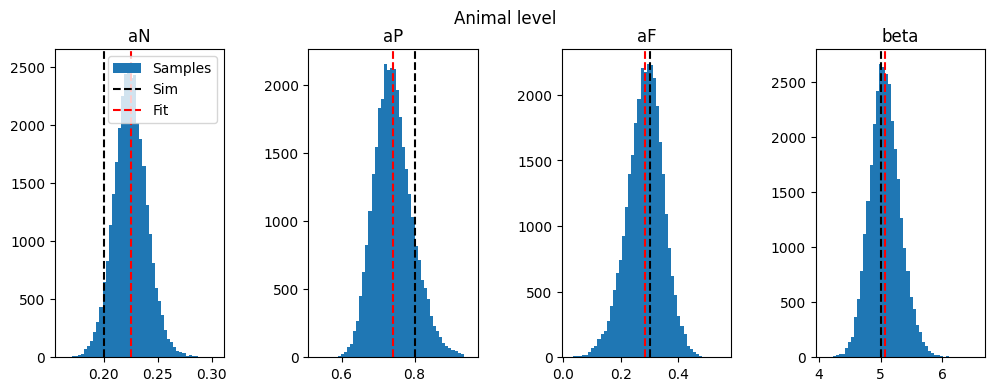

In [5]:
# animal level parameters
focus = 'mean' # or 'mode' or 'mad'
paramsAniFit = []
paramNamesNoBias = []
for paramName in b['paramNames']:
    if 'bias' not in paramName:
        curr = summary.loc[summary.index.str.startswith(f'mu_{paramName}'), focus].values[0]
        paramsAniFit.append(curr)
        paramNamesNoBias.append(paramName)
paramsAniFit = dict(zip(paramNamesNoBias, paramsAniFit)) 
# compare animal level sim, fit and distribution
plt.figure(figsize=(12, 4))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
for paramInd, paramName in enumerate(paramNamesNoBias):
    currSamples = fit[f'mu_{paramName}'].flatten()
    plt.subplot(1, len(paramNamesNoBias), paramInd+1)
    plt.hist(currSamples, 50, label='Samples')
    plt.axvline(b['paramsAni'][paramInd], color = 'k', ls = '--', label = 'Sim')
    plt.axvline(paramsAniFit[paramName], color = 'r', ls = '--', label = 'Fit')
    plt.title(paramName)
    if paramInd == 0:
        plt.legend()

plt.suptitle('Animal level')

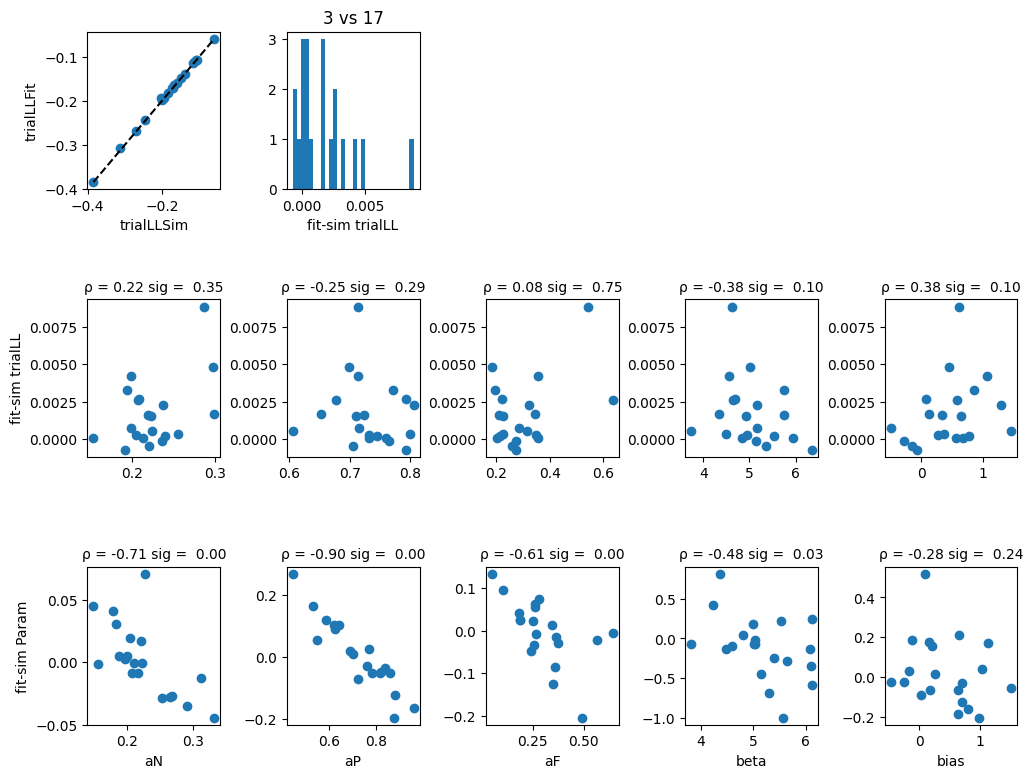

In [9]:
# value sim vs value fit
LHsim = []
LHfit = []
sessionInd = 0
for sessionInd in range(b['sessNum']):
    rlModelSim = QLearningModel(paramsSim.iloc[sessionInd].values)
    rlModelSim.fit(np.array(choiceSim[sessionInd]), np.array(outcomeSim[sessionInd]))
    LHsim.append(rlModelSim.LH/paramsSim.loc[sessionInd, 'sessionLen'])
    rlModelFit = QLearningModel(paramsFit.iloc[sessionInd].values)
    rlModelFit.fit(np.array(choiceSim[sessionInd]), np.array(outcomeSim[sessionInd]))
    LHfit.append(rlModelFit.LH/paramsSim.loc[sessionInd, 'sessionLen'])

plt.figure(figsize=(12, 9))
plt.subplots_adjust(hspace=0.7, wspace=0.5)
plt.subplot(3,5,1)
plt.scatter(LHsim, LHfit)
plt.plot([min(LHsim), max(LHsim)], [min(LHsim), max(LHsim)], 'k', ls = '--')
plt.xlabel('trialLLSim')
plt.ylabel('trialLLFit')

plt.subplot(3,5,2)
plt.hist(np.array(LHfit)-np.array(LHsim), 30)
plt.xlabel('fit-sim trialLL')
plt.title(f'{np.sum(np.array(LHfit)<np.array(LHsim))} vs {np.sum(np.array(LHfit)>np.array(LHsim))}');

for paramInd, paramName in enumerate(b['paramNames']):
    plt.subplot(3,len(b['paramNames']),len(b['paramNames'])+paramInd+1)
    plt.scatter(paramsFit[paramName], np.array(LHfit) - np.array(LHsim))
    if paramInd == 0:
        plt.ylabel('fit-sim trialLL')
    rho, p = spearmanr(paramsFit[paramName], np.array(LHfit) - np.array(LHsim))
    plt.title(f"ρ = {rho:.2f} sig = {p: .2f}", fontsize = 10)

for paramInd, paramName in enumerate(b['paramNames']):
    plt.subplot(3,len(b['paramNames']),2*len(b['paramNames'])+paramInd+1)
    plt.scatter(paramsSim[paramName], np.array(paramsFit[paramName]) - np.array(paramsSim[paramName]))
    plt.xlabel(paramName)
    if paramInd == 0:
        plt.ylabel('fit-sim Param')
    rho, p = spearmanr(paramsSim[paramName], np.array(paramsFit[paramName]) - np.array(paramsSim[paramName]))
    plt.title(f"ρ = {rho:.2f} sig = {p: .2f}", fontsize = 10)



# plt.subplot(2,5,4)
# plt.scatter(paramsFit['beta'], np.array(paramsFit['beta']) - np.array(paramsSim['beta']))
# plt.xlabel('beta')
# plt.ylabel('delta(beta)')
# rho, p = spearmanr(paramsFit['beta'],  np.array(paramsFit['beta']) - np.array(paramsSim['beta']))
# plt.title(f"ρ = {rho:.2f} sig = {p: .2f}", fontsize = 10)
# plt.subplot(2,5,6)
# plt.scatter(paramsFit['beta'], np.array(LHfit) - np.array(LHsim))
# plt.xlabel('beta')
# plt.ylabel('fit-sim')
# rho, p = spearmanr(paramsFit['beta'], np.array(LHfit) - np.array(LHsim))
# plt.title(f"ρ = {rho:.2f} sig = {p: .2f}", fontsize = 10)

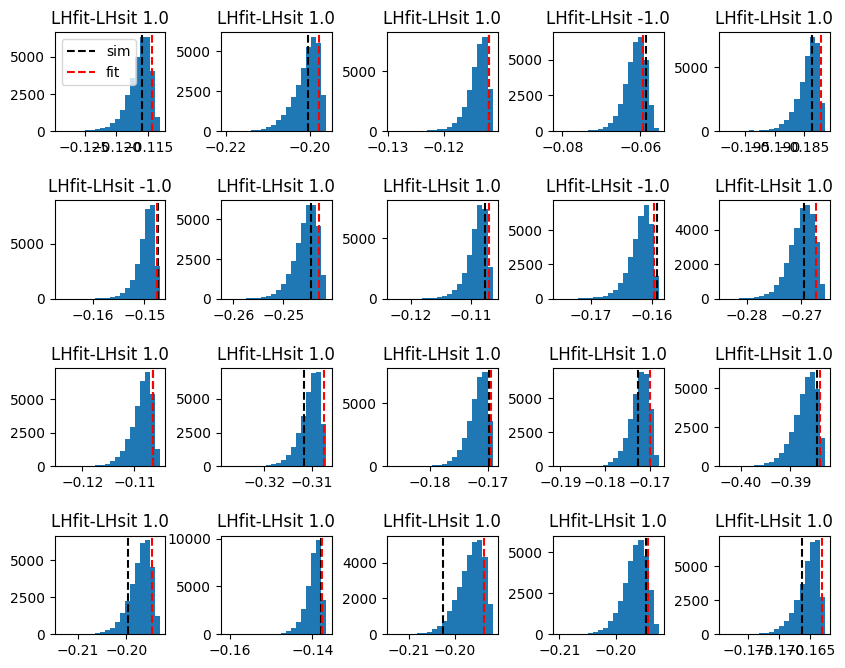

In [8]:
fig = plt.figure(figsize = (10, 10))
plt.subplots_adjust(hspace=0.7, wspace=0.5)
allLogLik = fit['log_lik']
col = int(np.ceil(np.sqrt(len(paramsSim))))
for sessionInd in range(len(paramsSim)):
    
    plt.subplot(col, col, sessionInd+1)
    rlModelSim = QLearningModel(paramsSim.iloc[sessionInd].values)
    rlModelSim.fit(np.array(choiceSim[sessionInd]), np.array(outcomeSim[sessionInd]))
    LH = rlModelSim.LH/paramsSim.loc[sessionInd, 'sessionLen']
    plt.hist(allLogLik[sessionInd,]/paramsSim.loc[sessionInd, 'sessionLen'], 20)
    plt.axvline(x = LH, color = 'k', ls = '--', label = 'sim')
    plt.axvline(x = LHfit[sessionInd], color = 'r', ls = '--', label = 'fit')
    plt.title(f'LHfit-LHsit {np.sign(LHfit[sessionInd]-LHsim[sessionInd])}')
    if sessionInd == 0:
        plt.legend()

/tmp/ipykernel_12139/4046695876.py:7: DeprecationWarning: This function is deprecated. Please call randint(0, 31999 + 1) instead
  sampInds = np.random.random_integers(0, np.shape(fit['mu_aF'])[1]-1, sampNum)


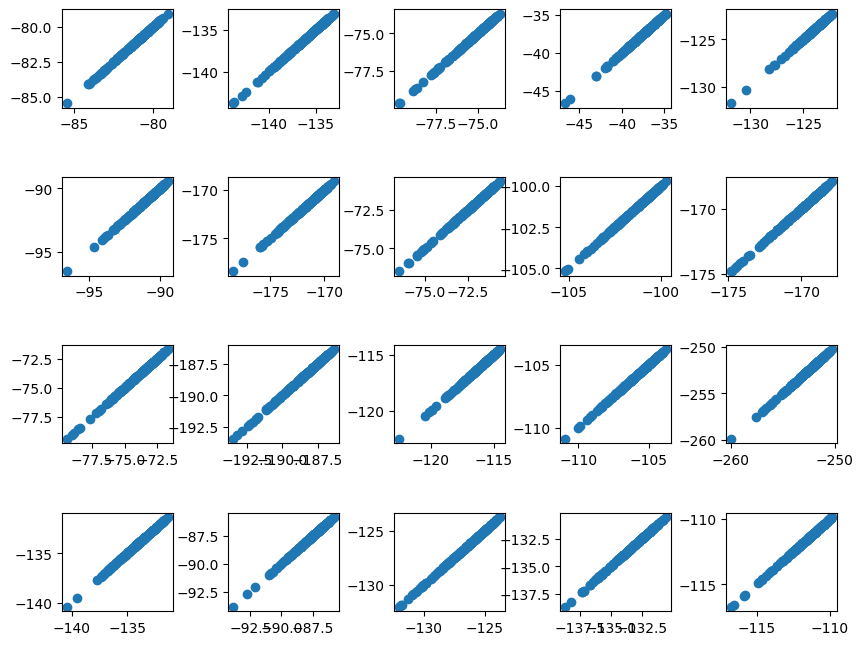

In [20]:
# fig = plt.figure(figsize = (10, 10))
# plt.subplots_adjust(hspace=0.7, wspace=0.5)
# allLogLik = fit['log_lik']
# col = int(np.ceil(np.sqrt(len(paramsSim))))
# sampNum = 200
# for sessionInd in range(len(paramsSim)):
#     sampInds = np.random.random_integers(0, np.shape(fit['mu_aF'])[1]-1, sampNum)
#     plt.subplot(col, col, sessionInd+1)
#     sessionParams = []

#     for paramName in b['paramNames']:
#         currSamples = fit[paramName]
#         currParams = currSamples[sessionInd, sampInds]
#         sessionParams.append(currParams)
#     sessionLL = fit['log_lik']
#     sessionLL = sessionLL[sessionInd, sampInds]
#     sessionParams = np.array(sessionParams).T
#     LHsimSess = np.ones_like(sessionLL)
#     for sampInd in range(sampNum):
#         rlModelSim = QLearningModel(sessionParams[sampInd,])
#         rlModelSim.fit(np.array(choiceSim[sessionInd]), np.array(outcomeSim[sessionInd]))
#         LHsimSess[sampInd] = rlModelSim.LH

#     plt.scatter(LHsimSess, sessionLL)

/tmp/ipykernel_11293/4046695876.py:7: DeprecationWarning: This function is deprecated. Please call randint(0, 31999 + 1) instead
  sampInds = np.random.random_integers(0, np.shape(fit['mu_aF'])[1]-1, sampNum)


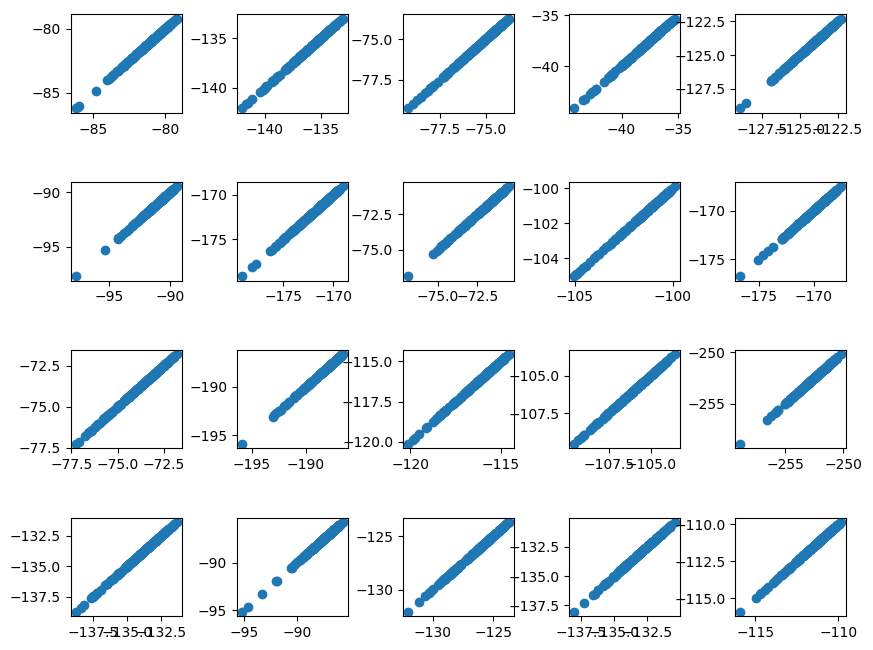

In [11]:
fig = plt.figure(figsize = (10, 10))
plt.subplots_adjust(hspace=0.7, wspace=0.5)
allLogLik = fit['log_lik']
col = int(np.ceil(np.sqrt(len(paramsSim))))
sampNum = 200
for sessionInd in range(len(paramsSim)):
    sampInds = np.random.random_integers(0, np.shape(fit['mu_aF'])[1]-1, sampNum)
    plt.subplot(col, col, sessionInd+1)
    sessionParams = []

    for paramName in b['paramNames']:
        currSamples = fit[paramName]
        currParams = currSamples[sessionInd, sampInds]
        sessionParams.append(currParams)
    sessionLL = fit['log_lik']
    sessionLL = sessionLL[sessionInd, sampInds]  
    sessionParams = np.array(sessionParams).T
    LHsimSess = np.ones_like(sessionLL)
    for sampInd in range(sampNum):
        rlModelSim = QLearningModel(sessionParams[sampInd,])
        rlModelSim.fit(np.array(choiceSim[sessionInd]), np.array(outcomeSim[sessionInd]))
        LHsimSess[sampInd] = rlModelSim.LH

    plt.scatter(LHsimSess, sessionLL)

In [ ]:
aniLevel = False
sessionInd = 0
sampInds = np.random.random_integers(0, np.shape(fit['mu_aF'])[1]-1, sampNum)
plt.subplot(col, col, sessionInd+1)
sessionParams = []

for paramName in b['paramNames']:
    currSamples = fit[paramName]
    currParams = currSamples[sessionInd, sampInds]
    sessionParams.append(currParams)
sessionLL = fit['log_lik']
sessionLL = sessionLL[sessionInd, sampInds]  
sessionParams = np.array(sessionParams).T
LHsimSess = np.ones_like(sessionLL)
for sampInd in range(sampNum):
    rlModelSim = QLearningModel(sessionParams[sampInd,])
    rlModelSim.fit(np.array(choiceSim[sessionInd]), np.array(outcomeSim[sessionInd]))
    LHsimSess[sampInd] = rlModelSim.LH
    QsumsimSess[sampInd] = rlModelSim.Q
    QsumsimSess[sampInd] = rlModelSim.Q

plt.scatter(LHsimSess, sessionLL)